In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [2]:
%cd '/content/drive/MyDrive/project/FaceSwapping/input/presidentsfacesdataset'
%ls

/content/drive/MyDrive/project/FaceSwapping/input/presidentsfacesdataset
biden/  trump/


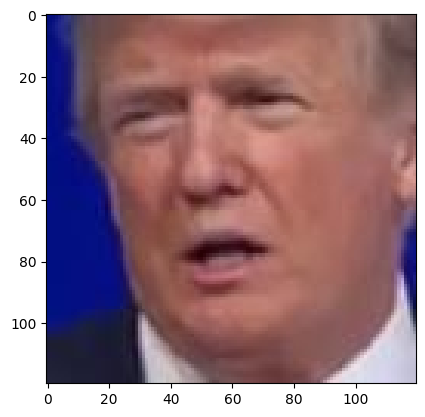

In [3]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/drive/MyDrive/project/FaceSwapping/input/presidentsfacesdataset/trump/1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32')
image /= 255.0
plt.imshow(image)
plt.show()

In [4]:
def create_dataset(path):
    images = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image = cv2.imread(os.path.join(dirname, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #rgb 형식으로 변경
            image = image.astype('float32')
            image /= 255.0  # normalizing
            images.append(image)
    images = np.array(images) #numpy array
    return images

In [5]:
faces_1 = create_dataset('/content/drive/MyDrive/project/FaceSwapping/input/presidentsfacesdataset/trump/')
faces_2 = create_dataset('/content/drive/MyDrive/project/FaceSwapping/input/presidentsfacesdataset/biden/')

In [6]:
print("Total President Trump face's samples: ",len(faces_1))
print("Total President Biden face's samples: ",len(faces_2))

Total President Trump face's samples:  2751
Total President Biden face's samples:  772


### Dataset Splitting

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(faces_1, faces_1, test_size=0.20, random_state=0)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(faces_2, faces_2, test_size=0.15, random_state=0)

In [9]:
X_train_a[0].shape

(120, 120, 3)

### Autoencoder Training
- 두 개의 autoencoder 구조
- encoder는 weights 공유, decoder는 각자 다른 weights
- encoder를 통해서 얼굴의 latent face를 추출.


### Face Swapping
- 얼굴 A를 encoding를 통해서 latent vector를 추출.
- latent vector를 B의 디코더에 입력
- A의 얼굴 움직임을 지니는 B를 출력.

In [10]:
#Making encoder:

input_img = layers.Input(shape=(120, 120, 3))
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(9216)(x)
encoded = layers.Reshape((3,3,1024))(x)

encoder = keras.Model(input_img, encoded,name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 256)       19456     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 512)       3277312   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 512)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 1024)        1310

In [11]:
#Making decoder:
decoder_input= layers.Input(shape=((3,3,1024)))
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((120, 120, 3)))(x)
decoded = layers.Reshape((120, 120, 3))(x)

decoder = keras.Model(decoder_input, decoded,name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 3, 1024)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 1024)        26215424  
                                                                 
 up_sampling2d (UpSampling2  (None, 4, 4, 1024)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 512)         13107712  
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 4, 4, 512)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 256)         3277

In [12]:
#Making autoencoder
auto_input = layers.Input(shape=(120,120,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)

autoencoder = keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 encoder (Functional)        (None, 3, 3, 1024)        54162944  
                                                                 
 decoder (Functional)        (None, 120, 120, 3)       86880192  
                                                                 
Total params: 141043136 (538.04 MB)
Trainable params: 141043136 (538.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# epochs = 500, batch_size = 512
checkpoint1 = ModelCheckpoint("/content/drive/MyDrive/project/FaceSwapping/working/autoencoder_a.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_freq="epoch")
# WARNING:tensorflow:Can save best model only with val_accuracy available, skipping -> save_freq를 1에서 epoch으로 수정.
history1 = autoencoder.fit(X_train_a, X_train_a,epochs=500,batch_size=512,shuffle=True,validation_data=(X_test_a, X_test_a),callbacks=[checkpoint1]) #원래 epochs = 2700

Epoch 1/500
5/5 [==============================] - ETA: 0s - loss: 0.1257
Epoch 1: val_loss improved from inf to 0.18956, saving model to /content/drive/MyDrive/project/FaceSwapping/working/autoencoder_a.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 64s 15s/step - loss: 0.1257 - val_loss: 0.1896
Epoch 2/500
5/5 [==============================] - ETA: 0s - loss: 0.1567
Epoch 2: val_loss improved from 0.18956 to 0.12870, saving model to /content/drive/MyDrive/project/FaceSwapping/working/autoencoder_a.hdf5
5/5 [==============================] - 22s 5s/step - loss: 0.1567 - val_loss: 0.1287
Epoch 3/500
5/5 [==============================] - ETA: 0s - loss: 0.0929
Epoch 3: val_loss improved from 0.12870 to 0.07623, saving model to /content/drive/MyDrive/project/FaceSwapping/working/autoencoder_a.hdf5
5/5 [==============================] - 27s 6s/step - loss: 0.0929 - val_loss: 0.0762
Epoch 4/500
5/5 [==============================] - ETA: 0s - loss: 0.1093
Epoch 4: val_loss did not improve from 0.07623
5/5 [==============================] - 9s 2s/step - loss: 0.1093 - val_loss: 0.1127
Epoch 5/500
5/5 [==============================] - ETA: 0s - loss: 0.1061
Epoch 5: val_loss did not improve from 

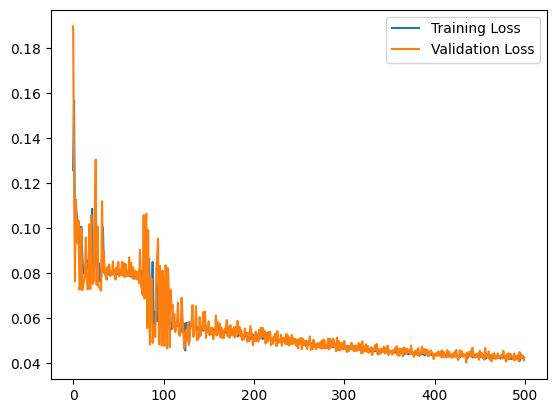

In [15]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()

In [16]:
autoencoder_a = load_model("/content/drive/MyDrive/project/FaceSwapping/working/autoencoder_a.hdf5")
autoencoder_a.evaluate(X_test_a, X_test_a)

18/18 [==============================] - 2s 64ms/step - loss: 0.0403


0.04027825593948364

In [17]:
output_image = autoencoder_a.predict(np.array([X_test_a[30]]))

1/1 [==============================] - 1s 621ms/step


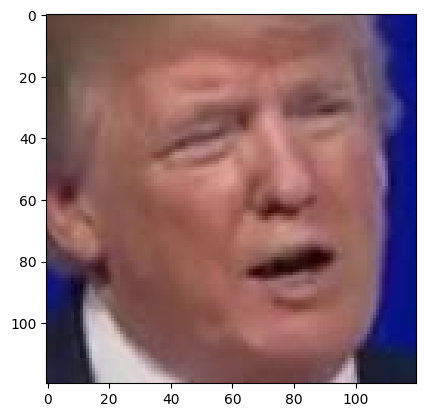

In [18]:
%matplotlib inline
plt.figure()
plt.imshow(X_test_a[30])
plt.show()

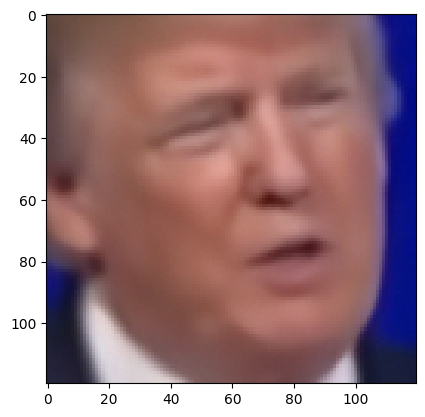

In [19]:
%matplotlib inline
plt.figure()
plt.imshow(output_image[0])
plt.show()

In [20]:
# TO LOAD ONLY THE ENCODER A
encoder_a = keras.Model(autoencoder_a.layers[1].input, autoencoder_a.layers[1].output)
# TO LOAD ONLY THE DECODER A
decoder_a = keras.Model(autoencoder_a.layers[2].input, autoencoder_a.layers[2].output)

In [21]:
input_test = encoder_a.predict(np.array([X_test_a[30]]))
output_test = decoder_a.predict(input_test)
output_test = decoder_a.predict(input_test)

1/1 [==============================] - 0s 79ms/step


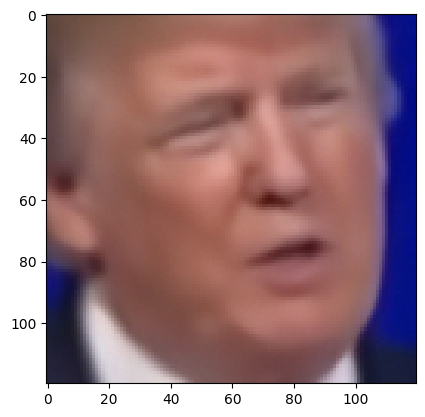

In [22]:
%matplotlib inline
plt.figure()
plt.imshow(output_test[0])
plt.show()

In [23]:
import gc
gc.collect()

9493

biden autoencoder 학습

In [24]:
checkpoint2 = ModelCheckpoint("/content/drive/MyDrive/project/FaceSwapping/working/autoencoder_b.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', save_freq="epoch")
history2 = autoencoder.fit(X_train_b, X_train_b,epochs=500,batch_size=512,shuffle=True,validation_data=(X_test_b, X_test_b),callbacks=[checkpoint2])

Epoch 1/500
2/2 [==============================] - ETA: 0s - loss: 0.1065
Epoch 1: val_loss improved from inf to 0.09257, saving model to /content/drive/MyDrive/project/FaceSwapping/working/autoencoder_b.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 26s 23s/step - loss: 0.1065 - val_loss: 0.0926
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 0.0916
Epoch 2: val_loss improved from 0.09257 to 0.08358, saving model to /content/drive/MyDrive/project/FaceSwapping/working/autoencoder_b.hdf5
2/2 [==============================] - 21s 19s/step - loss: 0.0916 - val_loss: 0.0836
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 0.0829
Epoch 3: val_loss improved from 0.08358 to 0.07943, saving model to /content/drive/MyDrive/project/FaceSwapping/working/autoencoder_b.hdf5
2/2 [==============================] - 14s 12s/step - loss: 0.0829 - val_loss: 0.0794
Epoch 4/500
2/2 [==============================] - ETA: 0s - loss: 0.0789
Epoch 4: val_loss improved from 0.07943 to 0.07671, saving model to /content/drive/MyDrive/project/FaceSwapping/working/autoencoder_b.hdf5
2/2 [==============================] - 17s 15s/step - loss: 0.0789 - val_loss: 0.0767
Epoch 5/500
2/2 [

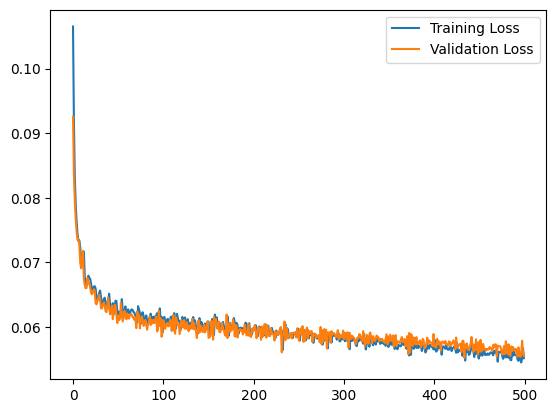

In [25]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()

In [26]:
autoencoder_b = load_model("/content/drive/MyDrive/project/FaceSwapping/working/autoencoder_b.hdf5")
autoencoder_b.evaluate(X_test_b, X_test_b)

4/4 [==============================] - 1s 298ms/step - loss: 0.0552


0.055208273231983185

In [27]:
output_image = autoencoder_b.predict(np.array([X_test_b[0]]))

1/1 [==============================] - 0s 214ms/step


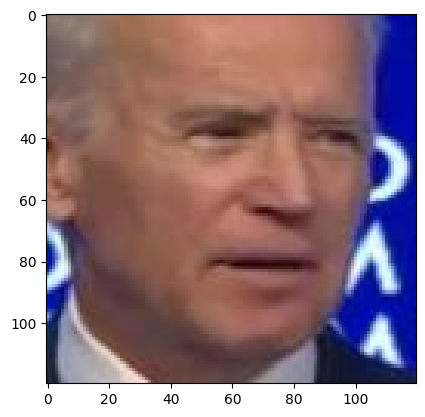

In [28]:
%matplotlib inline
plt.figure()
plt.imshow(X_test_b[0])
plt.show()

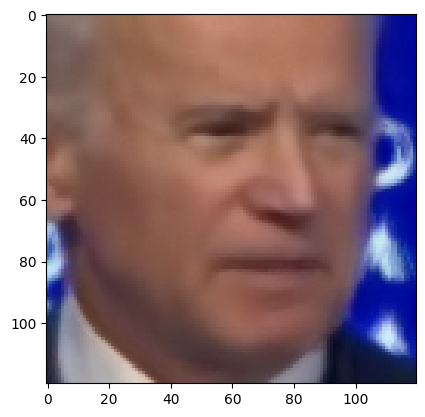

In [29]:
%matplotlib inline
plt.figure()
plt.imshow(output_image[0])
plt.show()